[我在AI Studio上获得钻石等级，点亮9个徽章，来互关呀~]( https://aistudio.baidu.com/aistudio/personalcenter/thirdview/335435)


# 飞桨常规赛：PALM病理性近视预测 - 7月第1名方案


# (1) 比赛介绍


## 赛题介绍
PALM病理性近视预测常规赛的重点是研究和发展与病理性近视诊断相关的算法。该常规赛的目标是评估和比较在一个常见的视网膜眼底图像数据集上检测病理性近视的自动算法。具体任务是将提供的图像分为病理性近视眼底彩照和非病理性近视眼底彩照，其中，非病理性近视眼底彩照包括正常眼底和高度近视眼底彩照。

![](https://ai-studio-static-online.cdn.bcebos.com/ed9fa131e1ef4f2bb82faf1a93c04a2a9156a5bb94474081ac83e19ebcd479d1)#

## 数据简介
PALM病理性近视预测常规赛由中山大学中山眼科中心提供800张带病理性近视分类标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。

## 数据说明
本次常规赛提供的病理性近视分类金标准是从临床报告中获取，不仅基于眼底彩照，还结合了OCT、视野检查等结果。

## 训练数据集
文件名称：Train
Train文件夹里有一个fundus_image文件夹和一个Classification.xlsx文件。fundus_image文件夹中数据均为眼底彩照，分辨率为1444×1444，或2124×2056。命名形如N0001.jpg、H0001.jpg、P0001.jpg和V0001.jpg。Classification.xlsx文件中为各眼底图像是否属于病理性近视，属于为1，不属于为0。

## 测试数据集
文件名称：PALM-Testing400-Images 文件夹里包含400张眼底彩照，命名形如T0001.jpg。

# （2）个人思路

## 自定义数据集读取图片和标签
```
import paddle
import cv2
import numpy as np
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_list,mode='train'):

        self.image=img_list
        self.label=label_list
        self.mode=mode
    def load_img(self, image_path):

        img=cv2.imread(image_path,1)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img

    def __getitem__(self,index):
        img = self.load_img(self.image[index])
        label = self.label[index]

        if self.mode=='train':
            img=train_transform(img)
        else:
            img=val_transform(img)

        #label=np.array([label])
        label=onehot(2,label)
        label = paddle.to_tensor(label)

        return img,paddle.nn.functional.label_smooth(label)

    def __len__(self):
        return len(self.image)
        
```
## 使用数据增强方法对数据进行增广
```
import paddle.vision.transforms as T
train_transform = T.Compose([
                        T.Resize(size=[224,224]),
                        T.ColorJitter(0.1, 0.1, 0.1, 0.1),
                        T.RandomVerticalFlip(0.3),
                        T.RandomHorizontalFlip(0.3),
                        T.RandomRotation(30),
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])
```
## 异步加载数据

```
train_loader = paddle.io.DataLoader(train_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=True, num_workers=0)
val_loader = paddle.io.DataLoader(val_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=True, num_workers=0)
```
## 使用预训练模型进行训练
如：resnet50、resnet101、resnet152、mobilenet_v1、mobilenet_v2等

`net=paddle.vision.resnet152(pretrained=True)`


## 使用 cosine annealing 的策略来动态调整学习率

`lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=3e-4,T_max=step_each_epoch * EPOCHS)`

## L2权重衰减正则化
`weight_decay=paddle.regularizer.L2Decay(0.00001)`

## 软标签（每个样本以一定的概率被分配至多个类别中，概率和为1）
`soft_label=True`

## 使用paddle.metric.Auc进行评估

```
m = paddle.metric.Auc()

n = 8
class0_preds = np.random.random(size = (n, 1))
class1_preds = 1 - class0_preds

preds = np.concatenate((class0_preds, class1_preds), axis=1)
labels = np.random.randint(2, size = (n, 1))

m.update(preds=preds, labels=labels)
res = m.accumulate()
```

# （3）具体方案分享

代码参考：

[飞桨常规赛：PALM病理性近视预测5月第9名方案](https://aistudio.baidu.com/aistudio/projectdetail/1975821)

[飞桨常规赛：PALM病理性近视预测6月第2名方案](https://aistudio.baidu.com/aistudio/projectdetail/2027635)




## 解压数据集

In [ ]:
!unzip -oq /home/aistudio/data/data98612/常规赛：PALM病理性近视预测.zip

In [ ]:
!rm -fr __MACOSX

## 查看数据标签

In [ ]:
import blackhole.dataframe as pd
df=pd.read_excel('常规赛：PALM病理性近视预测/Train/Classification.xlsx')
df.head()

,imgName,Label
0,H0001.jpg,0
1,H0002.jpg,0
2,H0003.jpg,0
3,H0004.jpg,0
4,H0005.jpg,0


## 数据增强

In [ ]:
import paddle.vision.transforms as T
train_transform = T.Compose([
                        T.Resize(size=[224,224]),                       
                        T.ColorJitter(0.1, 0.1, 0.1, 0.1),
                        T.RandomVerticalFlip(0.3),
                        T.RandomHorizontalFlip(0.3),
                        T.RandomRotation(30),
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])
val_transform=T.Compose([
                        T.Resize(size=[224,224]),
                        T.Normalize(mean=[127.5, 127.5, 127.5],std=[127.5, 127.5, 127.5],data_format='HWC'),
                        T.ToTensor(),
                        ])

## 自定义数据集

In [ ]:
path='常规赛：PALM病理性近视预测/Train/fundus_image/'
df=df.sample(frac=1)
image_list=[]
label_list=[]
for i in range(len(df)):
    image_list.append(path+df['imgName'][i])
    label_list.append(df['Label'][i])


In [ ]:
import os
test_path='常规赛：PALM病理性近视预测/PALM-Testing400-Images'
test_list=[]
test_label=[]
FileName=[]
list = os.listdir(test_path)  # 列出文件夹下所有的目录与文件
for i in range(0, len(list)):
    path = os.path.join(test_path, list[i])
    test_list.append(path)
    test_label.append(0)
    FileName.append(list[i])


In [ ]:
def onehot(size, target):
    vec = paddle.zeros([size], dtype='float32')
    vec[target] = 1.
    return vec

In [ ]:
import paddle
import cv2
import numpy as np
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_list,mode='train'):

        self.image=img_list
        self.label=label_list
        self.mode=mode
    def load_img(self, image_path):

        img=cv2.imread(image_path,1)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        return img

    def __getitem__(self,index):
        img = self.load_img(self.image[index])
        label = self.label[index]

        if self.mode=='train':
            img=train_transform(img)
        else:
            img=val_transform(img)

        label=onehot(2,label)
        label = paddle.to_tensor(label)

        return img,paddle.nn.functional.label_smooth(label)

        
    def __len__(self):
        return len(self.image)


### 训练集、验证集、测试集

In [ ]:
radio=0.8

train_ds=dataset(image_list[:int(len(image_list)*radio)],label_list[:int(len(label_list)*radio)],'train')
val_ds=dataset(image_list[int(len(image_list)*radio):],label_list[int(len(label_list)*radio):],'valid')
test_ds=dataset(test_list,test_label,'test')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


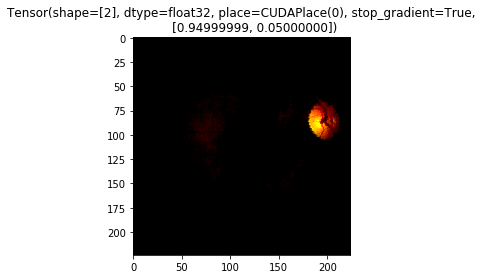

In [ ]:
import matplotlib.pyplot as plt
for i,data in enumerate(train_ds):
    img,label=data

    img=img.transpose([1,2,0])
    plt.imshow(img)
    plt.title(label)
    plt.show()
    if i==0:
        break

## 使用预训练模型

In [ ]:
import paddle.nn as F
class MyNet(paddle.nn.Layer):
    def __init__(self,num_classes=2):
        super(MyNet,self).__init__()
        self.net=paddle.vision.resnet152(pretrained=True)
        self.fc=paddle.nn.Linear(1000,num_classes)

    def forward(self,inputs):
        out=self.net(inputs)
        out=self.fc(out)
        return out

## 异步加载数据

In [ ]:
train_loader = paddle.io.DataLoader(train_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=True, num_workers=0)
val_loader = paddle.io.DataLoader(val_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)

## 模型训练与可视化

#### 如果图片尺寸较大应适当调小Batch_size，防止爆显存。

In [15]:
visualdl=paddle.callbacks.VisualDL(log_dir='visual_log')
#定义输入
input_define = paddle.static.InputSpec(shape=[-1,3,224,224], dtype="float32", name="img")
label_define = paddle.static.InputSpec(shape=[-1,1], dtype="int64", name="label")
Batch_size=32
EPOCHS=1
step_each_epoch = len(train_ds)//Batch_size

network=MyNet()
model = paddle.Model(network,inputs=input_define,labels=label_define)  # 模型封装


lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=3e-5,
                                                T_max=step_each_epoch * EPOCHS)
model.load('/home/aistudio/work/lup/final')
# 配置优化器、损失函数、评估指标
model.prepare(paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters(),weight_decay=paddle.regularizer.L2Decay(0.00001)), 
              paddle.nn.CrossEntropyLoss(soft_label=True), 
              paddle.metric.Accuracy())



In [16]:
# 训练可视化VisualDL工具的回调函数

# 启动模型全流程训练
model.fit(train_loader,  # 训练数据集
          val_loader,   # 评估数据集
          epochs=EPOCHS,       # 训练的总轮次
          batch_size=Batch_size,  # 训练使用的批大小 
          shuffle=True,
          save_dir="/home/aistudio/work/lup", #把模型参数、优化器参数保存至自定义的文件夹
          save_freq=1,                    #设定每隔多少个epoch保存模型参数及优化器参数
          verbose=1 ,      # 日志展示形式
          callbacks=[visualdl]
          )  # 设置可视化

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/1


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 20/20 [==============================] - loss: 0.2049 - acc: 1.0000 - 2s/step          
save checkpoint at /home/aistudio/work/lup/0
Eval begin...
step 5/5 [==============================] - loss: 0.2010 - acc: 1.0000 - 2s/step
Eval samples: 160
save checkpoint at /home/aistudio/work/lup/final


## 模型评估

In [18]:
# 模型评估

model.load('/home/aistudio/work/lup/final')
result = model.evaluate(val_loader, verbose=1)
print(result)


Eval begin...
step 5/5 [==============================] - loss: 0.2010 - acc: 1.0000 - 2s/step
Eval samples: 160
{'loss': [0.20098513], 'acc': 1.0}


In [19]:
# 使用 paddle.metric.Auc 进行模型评估
m = paddle.metric.Auc()

val_result = model.predict(val_ds)
val_result = paddle.to_tensor(val_result)
softmax = paddle.nn.Softmax()
val_result =softmax(val_result)
val_pred =np.array(val_result).reshape(-1,2)

val_label=label_list[int(len(label_list)*radio):]

val_label=np.array(val_label)

val_label=val_label.reshape(-1,1)

m.update(preds=val_pred, labels=val_label)
res = m.accumulate()


print(res)



Predict begin...
step 160/160 [==============================] - 70ms/step        
Predict samples: 160
1.0


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


## 进行预测操作

In [20]:


# 进行预测操作
result = model.predict(test_ds)

Predict begin...
step 400/400 [==============================] - 69ms/step         
Predict samples: 400


## 生成结果文件

In [21]:
x = paddle.to_tensor(result)
m = paddle.nn.Softmax()
out = m(x)
out=np.array(out).reshape(-1,2)
PMRisk=out[:,1]

submission = pd.DataFrame(data={
                            "FileName": FileName,
                            "PM Risk": PMRisk
                        })
submission=submission.sort_values(by='FileName')
submission.to_csv("result.csv", index=False)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


## 结果文件查看

In [22]:
submission.head()

,FileName,PM Risk
256,T0001.jpg,0.953847
293,T0002.jpg,0.068521
143,T0003.jpg,0.031756
97,T0004.jpg,0.978645
231,T0005.jpg,0.967379


## 结果投票集成
简单投票集成学习，这个可以提升效果，尽量选得分高的进行投票。

在统计学和机器学习中，集成学习方法使用多种学习算法来获得比单独使用任何单独的学习算法更好的预测性能。

使用不同超参数、不同的特征，不同的结构，运行多次模型可得到不同的预测结果。在这里我使用的是简单投票法，取PM Risk 平均值作为最终的预测结果。 预测出多个result后，进行投票，代码如下：

In [ ]:
import numpy as np
import blackhole.dataframe as pd
df1=pd.read_csv('result0.99887.csv')
df2=pd.read_csv('result0.99862.csv')
df3=pd.read_csv('result0.99714.csv')
df4=pd.read_csv('result0.9969100.csv')
df5=pd.read_csv('result0.99689.csv')
df6=pd.read_csv('result0.99628.csv')
df7=pd.read_csv('result0.99643.csv')

dfs=[df1,df2,df3,df4,df5,df6,df7]
PM_Risk=[]
File_Name=[]

for i in range(len(df1)):
    File_Name.append(dfs[0]['FileName'][i])
    avg=(sum(np.array(dfs[x]['PM Risk'][i]) for x in range(len(dfs))))/len(dfs)
  
    
    PM_Risk.append(avg)

submission = pd.DataFrame(data={
                            "FileName": File_Name,
                            "PM Risk": PM_Risk
                        })
submission=submission.sort_values(by='FileName')
submission.to_csv("resultx.csv", index=False)
    


# （4）比赛总结及改善方向：

1、多试几个的预训练模型。

2、使用 cosine annealing 的策略来动态调整学习率。

3、使用soft_label软标签。

4、使用数据增强能提分，但是用多了有时会起反作用，把 CenterCrop 去掉更容易提分，这个纯属个人感觉。

5、以前一直用Accuracy评估模型，比赛后，学会了用Auc评估模型。

6、在model.fit时用paddle.metric.Auc（）评估，loss降到一定值后就不降了，可能是我打开的方式不对。于是改成了训练时用Accuracy，评估时两个都用。

7、及时保存，把save_freq设置成1，用验证集对准确率高的进行评估和预测。对Auc值高的进行load,然后改几个参数接着训练，这对提高Score很有帮助。

8、以前一直认为使用较大的图片尺寸，可能效果更好。但是后来发现，不管的图片尺寸大还是小，只要准确率达到100%，Score就会成为1。

9、投票方法能提高成绩，但是存在天花板。

# （5）飞桨使用体验+给其他选手学习飞桨的建议
建议大家多参加百度AI Studio课程，多看别人写的AI Studio项目，也许会有灵感迸发，在比赛中取得更好的成绩。

# （6）One More Thing
## 病理性近视预测相关论文

1.[Pathological myopia classification with simultaneous lesion segmentation using deep learning](https://www.sciencedirect.com/science/article/pii/S0169260720317533)

2.[Detection of Pathological Myopia and Optic Disc Segmentation with Deep Convolutional Neural Networks](https://ieeexplore.ieee.org/abstract/document/8929252/)

[ 我在AI Studio上获得钻石等级，点亮9个徽章，来互关呀~](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/335435) 